
# 📘 Proyección Mortalidad ECV hasta 2050 — Modelo Regularizado (anti-sobreajuste)
**Autora:** Sofía Geraldine Vaca Cáceres  
**Ciudades:** Bogotá, Medellín, Cali, Barranquilla

Incluye:
- Limpieza/armonización robusta
- GLM Poisson **regularizado** (Ridge) con **validación temporal**
- Función **`predecir(...)`**
- **Proyección 2026–2050** (Base, +1 °C, +2 °C) con **gráficas inline**

> Si ves este texto, el notebook se generó correctamente.


In [ ]:
print('✅ Notebook cargado. Ejecuta las celdas en orden.')

## 1) Setup

In [1]:

# !pip install statsmodels patsy scipy --quiet

import re, unicodedata, warnings, math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import patsy as pt
import statsmodels.api as sm

plt.rcParams['figure.dpi'] = 150

DATA_TEMP = Path('/content/temperaturas.csv')
DATA_HUM  = Path('/content/humedad_relativa.csv')
DATA_MORT = Path('/content/Mortalidad.csv')


## 2) Utilidades

In [2]:

def read_scsv(path: Path) -> pd.DataFrame:
    try:
        return pd.read_csv(path, sep=';', decimal=',', engine='python')
    except Exception:
        return pd.read_csv(path)

def strip_accents(s: str) -> str:
    s = str(s)
    return ''.join(c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c) != 'Mn')

def norm_colname(c: str) -> str:
    c2 = strip_accents(c).lower().strip()
    c2 = re.sub(r'\s+', ' ', c2)
    c2 = c2.replace('(', '').replace(')', '').replace('.', '').replace(',', '')
    c2 = c2.replace('-', ' ').replace('/', ' ')
    c2 = re.sub(r'\s+', '_', c2)
    return c2

def normalize_columns(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df.columns = [norm_colname(c) for c in df.columns]
    return df

def first_present(df: pd.DataFrame, names) -> str|None:
    for n in names:
        if n in df.columns:
            return n
    return None

def ensure_ciudad(df: pd.DataFrame, prefer_city=True) -> pd.DataFrame:
    df = df.copy()
    if 'ciudad' in df.columns:
        return df
    col_city = first_present(df, ['city','ciudad'])
    col_mun  = first_present(df, ['municipio'])
    if prefer_city and col_city is not None:
        df.rename(columns={col_city:'ciudad'}, inplace=True); return df
    if col_city is None and col_mun is not None:
        def from_mun(x):
            s = str(x)
            if ' - ' in s: return s.split(' - ',1)[1].strip()
            return s.strip()
        df['ciudad'] = df[col_mun].map(from_mun); return df
    if col_city is not None:
        df.rename(columns={col_city:'ciudad'}, inplace=True); return df
    raise KeyError('No encontré columna de ciudad (city/ciudad/municipio).')

def std_city_name(x: str) -> str:
    s = strip_accents(str(x)).lower().strip()
    if 'bogota' in s: return 'Bogotá'
    if 'medell' in s: return 'Medellín'
    if 'cali' in s: return 'Cali'
    if 'barranq' in s: return 'Barranquilla'
    if s.startswith('bogota'): return 'Bogotá'
    return str(x).strip()

def week_monday(year, week):
    w = int(max(1, min(53, int(week))))
    return pd.to_datetime(f'{int(year)}-W{w:02d}-1', format='%G-W%V-%u', errors='coerce')


## 3) Carga y armonización

In [3]:

t = normalize_columns(read_scsv(DATA_TEMP))
h = normalize_columns(read_scsv(DATA_HUM))
m = normalize_columns(read_scsv(DATA_MORT))

for df in (t,h,m):
    col_y = first_present(df, ['ano','anio','year','year_date','yeardate','yearfecha'])
    if col_y and col_y!='anio': df.rename(columns={col_y:'anio'}, inplace=True)
    col_w = first_present(df, ['semana','week','wk'])
    if col_w and col_w!='semana': df.rename(columns={col_w:'semana'}, inplace=True)

if 'tmax' not in t.columns:
    cand = first_present(t, ['t_max','temp_max','tmax']);  t.rename(columns={cand:'tmax'}, inplace=True) if cand else None
if 'tmin' not in t.columns:
    cand = first_present(t, ['t_min','temp_min','tmin']);  t.rename(columns={cand:'tmin'}, inplace=True) if cand else None
if 'tmean' not in t.columns:
    cand = first_present(t, ['t_mean','temp_mean','tmean']); t.rename(columns={cand:'tmean'}, inplace=True) if cand else None

if 'humedad' not in h.columns:
    cand = first_present(h, ['rh','humedad_relativa','humedad','rel_humidity','relative_humidity'])
    if cand: h.rename(columns={cand:'humedad'}, inplace=True)

if 'muertes' not in m.columns:
    cand = first_present(m, ['mortalidad','defunciones','muertes_ecv','muertes'])
    if cand: m.rename(columns={cand:'muertes'}, inplace=True)

t = ensure_ciudad(t, prefer_city=True)
h = ensure_ciudad(h, prefer_city=True)
m = ensure_ciudad(m, prefer_city=True) if 'ciudad' in m.columns else ensure_ciudad(m, prefer_city=False)

t['ciudad'] = t['ciudad'].map(std_city_name)
h['ciudad'] = h['ciudad'].map(std_city_name)
m['ciudad'] = m['ciudad'].map(std_city_name)

for df in (t,h,m):
    df['anio'] = pd.to_numeric(df['anio'], errors='coerce').astype('Int64')
    df['semana'] = pd.to_numeric(df['semana'], errors='coerce').astype('Int64')

t = t[[c for c in ['anio','semana','ciudad','tmax','tmin','tmean'] if c in t.columns]].copy()
h = h[[c for c in ['anio','semana','ciudad','humedad'] if c in h.columns]].copy()
m = m[[c for c in ['anio','semana','ciudad','muertes'] if c in m.columns]].copy()

dfw = pd.merge(t, h, on=['anio','semana','ciudad'], how='left')
dfw = pd.merge(dfw, m, on=['anio','semana','ciudad'], how='left')
dfw['fecha'] = [week_monday(y,w) for y,w in zip(dfw['anio'], dfw['semana'])]
dfw = dfw.sort_values(['ciudad','fecha']).reset_index(drop=True)

if 'humedad' in dfw.columns:
    dfw['humedad'] = dfw.groupby('ciudad')['humedad'].transform(lambda s: s.fillna(s.median()))

print('Columnas dfw:', list(dfw.columns))
display(dfw.head(3))


Columnas dfw: ['anio', 'semana', 'ciudad', 'tmax', 'tmin', 'tmean', 'humedad', 'muertes', 'fecha']


,anio,semana,ciudad,tmax,tmin,tmean,humedad,muertes,fecha
0,2010,1,Barranquilla,30.754286,24.925714,27.840000,77.977143,13,2010-01-04
1,2010,2,Barranquilla,30.408571,25.112857,27.760714,75.570000,19,2010-01-11
2,2010,3,Barranquilla,31.718571,24.762857,28.240714,75.620000,10,2010-01-18


## 4) Diseño (splines suaves) y GLM Poisson regularizado

In [4]:

def available_temp_vars(df: pd.DataFrame):
    present = [v for v in ['tmax','tmin','tmean'] if v in df.columns]
    present = [v for v in present if df[v].notna().any()]
    return present

def formula_for(df: pd.DataFrame, df_temp=3, df_season=4):
    tv = available_temp_vars(df)
    if ('tmax' in tv) and ('tmin' in tv):
        temp_part = f"cr(tmax, df={df_temp}) + cr(tmin, df={df_temp})"; rr_vars=['tmax','tmin']
    elif 'tmax' in tv:
        temp_part = f"cr(tmax, df={df_temp})"; rr_vars=['tmax']
    elif 'tmin' in tv:
        temp_part = f"cr(tmin, df={df_temp})"; rr_vars=['tmin']
    elif 'tmean' in tv:
        temp_part = f"cr(tmean, df={df_temp})"; rr_vars=['tmean']
    else:
        return None, []
    controls = f"cr(t_ordinal, df={df_season}) + year_sin + year_cos"
    if ('humedad' in df.columns) and (not df['humedad'].isna().all()):
        controls += " + humedad"
    return f"muertes ~ {temp_part} + {controls}", rr_vars

def build_controls(d: pd.DataFrame, origin=None):
    dd = d.copy()
    if origin is None:
        origin = dd['fecha'].min()
    dd['t_ordinal'] = (dd['fecha'] - origin).dt.days
    dd['year_sin']  = np.sin(2*np.pi*dd['t_ordinal']/365.25)
    dd['year_cos']  = np.cos(2*np.pi*dd['t_ordinal']/365.25)
    if 'humedad' in dd.columns:
        dd['humedad'] = dd['humedad'].fillna(dd['humedad'].median())
    return dd, origin

def poisson_deviance(y, mu, eps=1e-9):
    y = np.asarray(y, float); mu = np.asarray(mu, float)
    return 2.0*np.nansum(y*np.log((y+eps)/(mu+eps)) - (y - mu))

def fit_city_ridge_cv(df_city: pd.DataFrame, ciudad: str, alphas=(0.0,0.01,0.1,1.0,10.0), k_folds=5):
    d = df_city.dropna(subset=['muertes']).copy()
    if len(d) < 80: return None
    d, origin = build_controls(d)
    formula, rr_vars = formula_for(d, df_temp=3, df_season=4)
    if not formula: return None

    y, X = pt.dmatrices(formula, d, return_type='dataframe')
    cols = list(X.columns)
    intercept_idx = [i for i,c in enumerate(cols) if c.lower()=='intercept']
    scale = X.std(axis=0, numeric_only=True).replace(0,1.0)
    Xs = X.copy()
    for c in cols:
        if c.lower()=='intercept': continue
        if c in scale.index:
            Xs[c] = Xs[c] / (scale[c] if scale[c]!=0 else 1.0)

    n = len(y)
    fold_sizes = np.linspace(0.6, 0.9, k_folds)
    results = []
    for alpha in alphas:
        devs = []
        for frac in fold_sizes:
            split = int(n*frac)
            if split >= n-5: continue
            Xtr, ytr = Xs.iloc[:split,:], y.iloc[:split,:]
            Xva, yva = Xs.iloc[split:,:], y.iloc[split:,:]
            if intercept_idx:
                a_vec = np.ones(Xtr.shape[1]) * alpha
                a_vec[intercept_idx[0]] = 0.0
            else:
                a_vec = alpha
            model = sm.GLM(ytr, Xtr, family=sm.families.Poisson())
            try:
                res = model.fit_regularized(alpha=a_vec, L1_wt=0.0, maxiter=300)
            except Exception:
                res = model.fit()
            mu_va = res.predict(Xva)
            devs.append(poisson_deviance(yva.values.ravel(), mu_va))
        if devs:
            results.append((alpha, float(np.mean(devs))))
    if not results: return None
    best_alpha, best_dev = sorted(results, key=lambda t: t[1])[0]

    if intercept_idx:
        a_vec = np.ones(Xs.shape[1]) * best_alpha
        a_vec[intercept_idx[0]] = 0.0
    else:
        a_vec = best_alpha
    model_full = sm.GLM(y, Xs, family=sm.families.Poisson())
    try:
        res_full = model_full.fit_regularized(alpha=a_vec, L1_wt=0.0, maxiter=500)
    except Exception:
        res_full = model_full.fit()

    return {
        'ciudad': ciudad,
        'origin': origin,
        'rr_vars': rr_vars,
        'scale': scale,
        'design_info': X.design_info,
        'coef_': res_full.params,
        'alpha_opt': float(best_alpha),
        'cv_deviance': float(best_dev),
        'columns': cols,
        'intercept_name': [c for c in cols if c.lower()=='intercept'][0] if intercept_idx else None,
    }

def predict_with_fit(fit: dict, df_in: pd.DataFrame) -> np.ndarray:
    Xnew = pt.build_design_matrices([fit['design_info']], df_in)[0]
    Xnew = Xnew.copy()
    for c in fit['columns']:
        if c not in Xnew.columns:
            Xnew[c] = 0.0
    Xnew = Xnew[fit['columns']]
    for c in fit['columns']:
        if fit['intercept_name'] and c == fit['intercept_name']:
            continue
        if c in fit['scale'].index:
            s = fit['scale'][c]
            if s != 0:
                Xnew[c] = Xnew[c] / s
    xb = np.dot(Xnew.values, fit['coef_'])
    mu = np.exp(xb)
    return mu


## 5) Ajuste por ciudad con Ridge + CV temporal

In [5]:

fits = {}
rows = []
for ciudad, g in dfw.groupby('ciudad'):
    fit = fit_city_ridge_cv(g, ciudad, alphas=(0.0,0.01,0.1,1.0,10.0), k_folds=5)
    if fit is None:
        print(f'⚠️ {ciudad}: sin ajuste (datos insuficientes o sin temperatura).')
        continue
    fits[ciudad] = fit
    rows.append({'ciudad': ciudad, 'alpha_opt': fit['alpha_opt'], 'cv_deviance': fit['cv_deviance'], 'rr_vars': ','.join(fit['rr_vars'])})
cv_summary = pd.DataFrame(rows).sort_values('ciudad')
display(cv_summary)


,ciudad,alpha_opt,cv_deviance,rr_vars
0,Barranquilla,10.0,298.399408,"tmax,tmin"
1,Bogotá,10.0,684.663815,"tmax,tmin"
2,Cali,10.0,335.977650,"tmax,tmin"
3,Medellín,10.0,609.870004,"tmax,tmin"


## 6) Función `predecir(...)`

In [6]:

def predecir(df_futuro: pd.DataFrame, ciudad: str) -> pd.DataFrame:
    if ciudad not in fits:
        raise ValueError(f'No hay modelo entrenado para {ciudad}.')
    fit = fits[ciudad]
    d = df_futuro.copy()
    if 'fecha' in d.columns:
        origin = fit['origin']
        d['t_ordinal'] = (d['fecha'] - origin).dt.days
    else:
        d['t_ordinal'] = np.arange(len(d))
    d['year_sin']  = np.sin(2*np.pi*d['t_ordinal']/365.25)
    d['year_cos']  = np.cos(2*np.pi*d['t_ordinal']/365.25)
    if 'humedad' in d.columns:
        d['humedad'] = d['humedad'].fillna(d['humedad'].median())
    needed = fit['rr_vars']
    missing = [v for v in needed if v not in d.columns]
    if missing and ('tmean' in d.columns):
        for v in missing:
            d[v] = d['tmean']
        missing = [v for v in needed if v not in d.columns]
    if missing:
        raise ValueError(f'Faltan columnas requeridas por el modelo de {ciudad}: {missing}')
    mu = predict_with_fit(fit, d)
    d['yhat'] = mu
    return d


In [9]:
# === PARCHE: predict_with_fit robusta para DesignMatrix (sin .columns) ===
import pandas as pd
import numpy as np
import patsy as pt

def predict_with_fit(fit: dict, df_in: pd.DataFrame) -> np.ndarray:
    """
    Construye la matriz de diseño con el MISMO diseño que en el entrenamiento,
    la convierte a DataFrame, reescala columnas como se hizo al entrenar
    (excepto el intercepto), y aplica los coeficientes (link log).
    """
    # 1) Construir matriz de diseño nueva
    Xnew = pt.build_design_matrices([fit["design_info"]], df_in)[0]  # DesignMatrix

    # 2) Convertir a DataFrame con nombres de columnas correctos
    try:
        colnames = Xnew.design_info.column_names  # a veces está disponible aquí
    except Exception:
        colnames = fit["design_info"].column_names  # respaldo: usar los del entrenamiento
    Xdf = pd.DataFrame(np.asarray(Xnew), columns=colnames)

    # 3) Asegurar mismas columnas y mismo orden que en el ajuste
    for c in fit["columns"]:
        if c not in Xdf.columns:
            Xdf[c] = 0.0  # si faltara alguna, la creamos con 0
    Xdf = Xdf[fit["columns"]]  # reordenar exactamente como en el entrenamiento

    # 4) Reescalar con los factores usados en el ajuste (excepto el intercepto)
    for c in fit["columns"]:
        if fit["intercept_name"] and c == fit["intercept_name"]:
            continue
        if c in fit["scale"].index:
            s = fit["scale"][c]
            if s != 0:
                Xdf[c] = Xdf[c] / s

    # 5) Predicción (link log: mu = exp(X * beta))
    xb = np.dot(Xdf.values, fit["coef_"])
    mu = np.exp(xb)
    return mu


## 7) Backtest 80/20 rápido (diagnóstico)

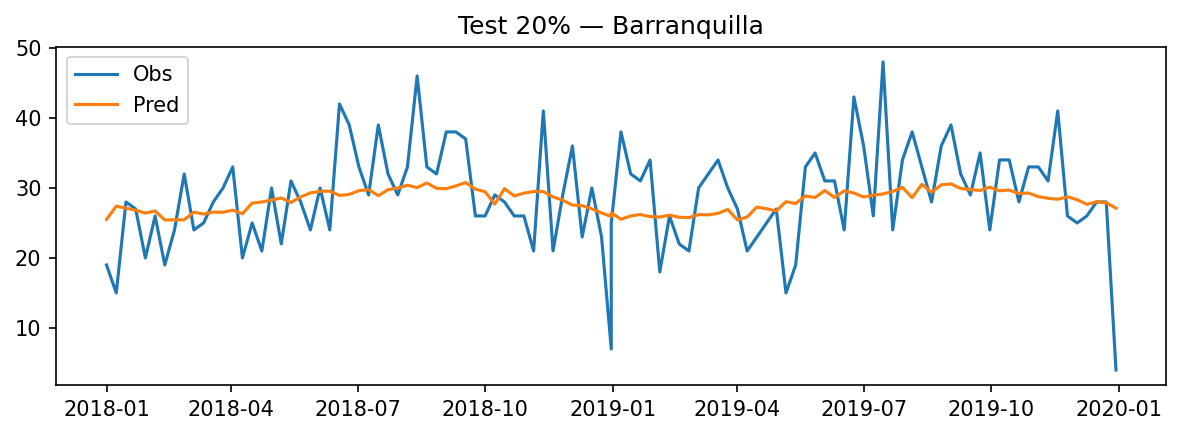

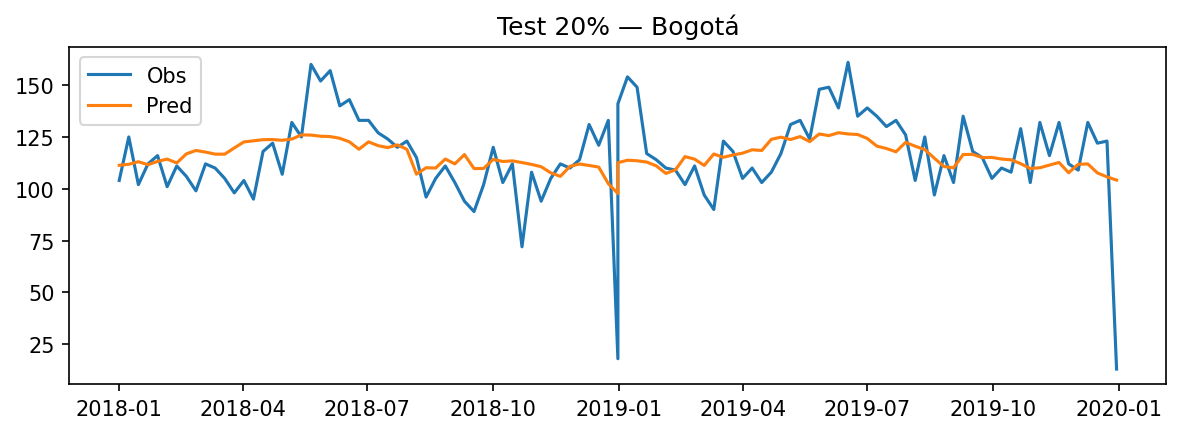

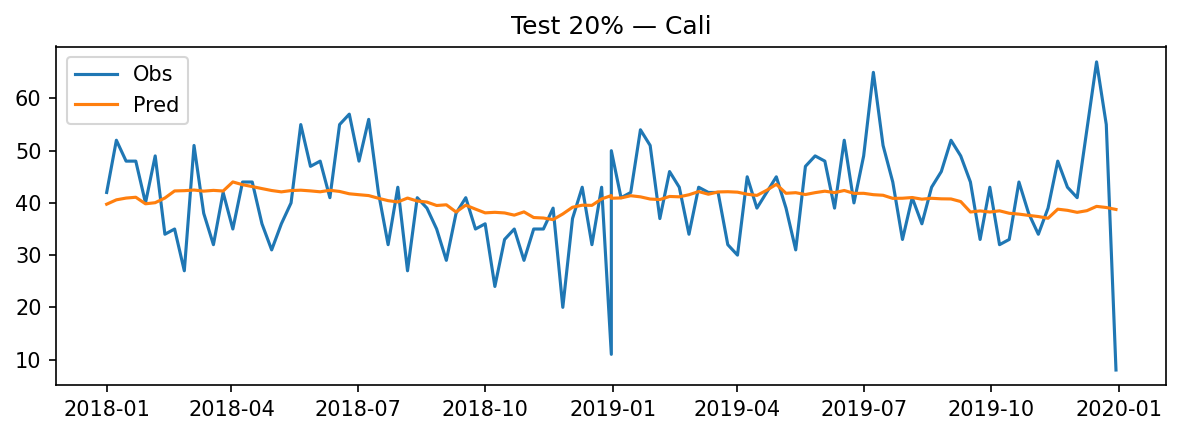

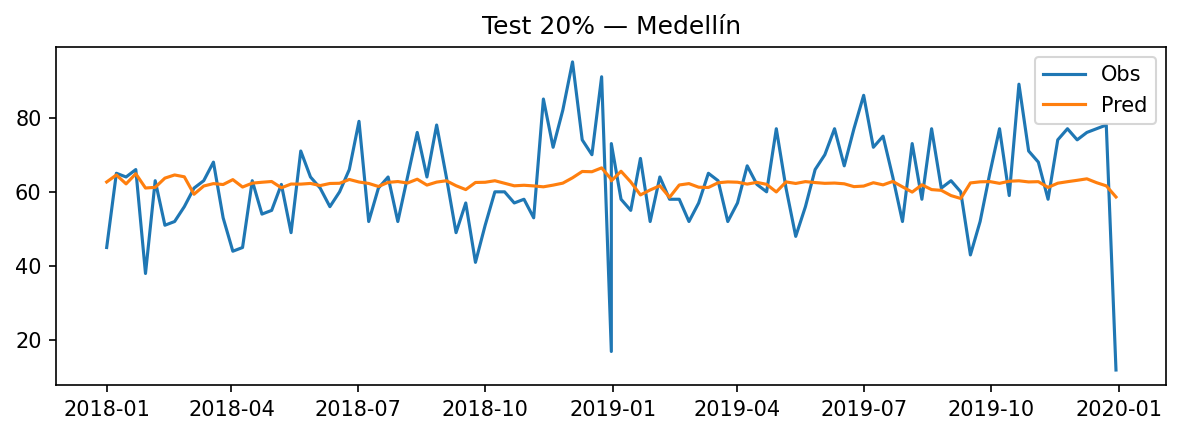

,ciudad,n_train,n_test,train_MAE,train_RMSE,train_Dev,train_R2,test_MAE,test_RMSE,test_Dev,test_R2
0,Barranquilla,424,106,4.409935,5.760728,652.673925,0.313822,5.159170,6.735291,183.896658,0.178414
1,Bogotá,424,106,11.905524,17.304340,1515.285946,0.155670,13.429870,19.201809,432.764993,0.278064
2,Cali,424,106,6.484814,8.652180,906.883271,0.117338,6.694215,9.063751,232.498530,0.051878
3,Medellín,424,106,7.641118,10.465118,1033.483319,0.312558,9.392469,12.703246,303.762717,0.031699


In [10]:

def metrics(y_true, y_pred):
    y_true = np.asarray(y_true, dtype=float); y_pred = np.asarray(y_pred, dtype=float)
    mae = np.mean(np.abs(y_true - y_pred)); rmse = np.sqrt(np.mean((y_true - y_pred)**2))
    eps = 1e-9
    dev = 2.0*np.nansum(y_true*np.log((y_true+eps)/(y_pred+eps)) - (y_true - y_pred))
    r = np.corrcoef(y_true, y_pred)[0,1] if len(y_true)>1 else np.nan
    r2 = r**2 if r==r else np.nan
    return mae, rmse, dev, r2

eval_rows = []
for ciudad, g in dfw.groupby('ciudad'):
    if (ciudad not in fits): continue
    d = g.dropna(subset=['muertes']).sort_values('fecha').copy()
    if len(d) < 60: continue
    fit = fits[ciudad]
    split = int(len(d)*0.8)
    train, test = d.iloc[:split].copy(), d.iloc[split:].copy()
    # preparar controles con el origen
    def _prep(df, ori=fit['origin']):
        dd = df.copy()
        dd['t_ordinal'] = (dd['fecha']-ori).dt.days
        dd['year_sin']  = np.sin(2*np.pi*dd['t_ordinal']/365.25)
        dd['year_cos']  = np.cos(2*np.pi*dd['t_ordinal']/365.25)
        if 'humedad' in dd.columns: dd['humedad'] = dd['humedad'].fillna(dd['humedad'].median())
        return dd
    tr, te = _prep(train), _prep(test)
    ytr = predict_with_fit(fit, tr); yte = predict_with_fit(fit, te)
    mtr = metrics(train['muertes'], ytr); mte = metrics(test['muertes'], yte)
    eval_rows.append({'ciudad': ciudad, 'n_train': len(train), 'n_test': len(test),
                      'train_MAE': mtr[0], 'train_RMSE': mtr[1], 'train_Dev': mtr[2], 'train_R2': mtr[3],
                      'test_MAE': mte[0], 'test_RMSE': mte[1], 'test_Dev': mte[2], 'test_R2': mte[3]})
    # gráfico rápido
    plt.figure(figsize=(8,3))
    plt.plot(test['fecha'], test['muertes'], label='Obs')
    plt.plot(test['fecha'], yte, label='Pred')
    plt.title(f'Test 20% — {ciudad}'); plt.legend(); plt.tight_layout(); plt.show()

pd.DataFrame(eval_rows).sort_values('ciudad')


## 8) Proyección semanal 2026–2050 (Base, +1 °C, +2 °C)

,fecha,yhat,ciudad,escenario
0,2026-01-05,23.688850,Barranquilla,Base
1,2026-01-12,23.251117,Barranquilla,Base
2,2026-01-19,23.510756,Barranquilla,Base
3,2026-01-26,23.326824,Barranquilla,Base
4,2026-02-02,23.467113,Barranquilla,Base


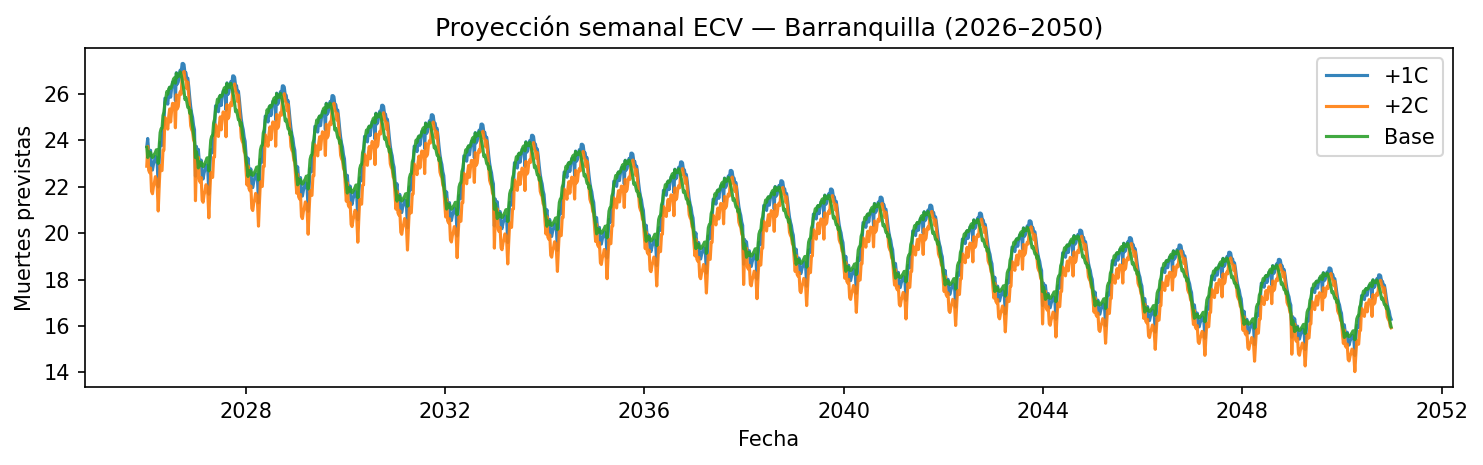

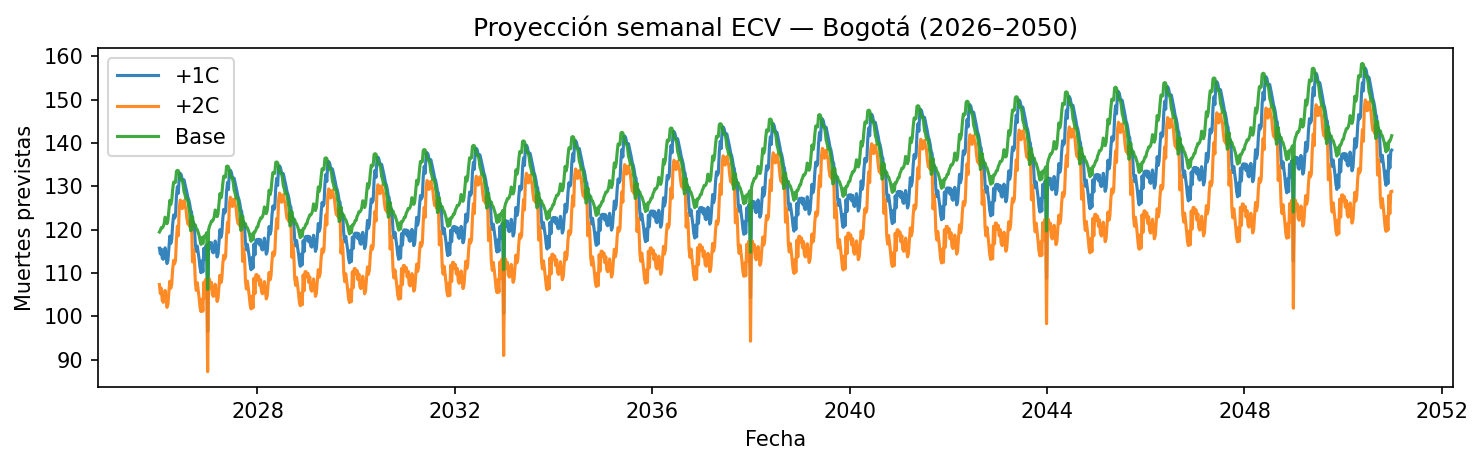

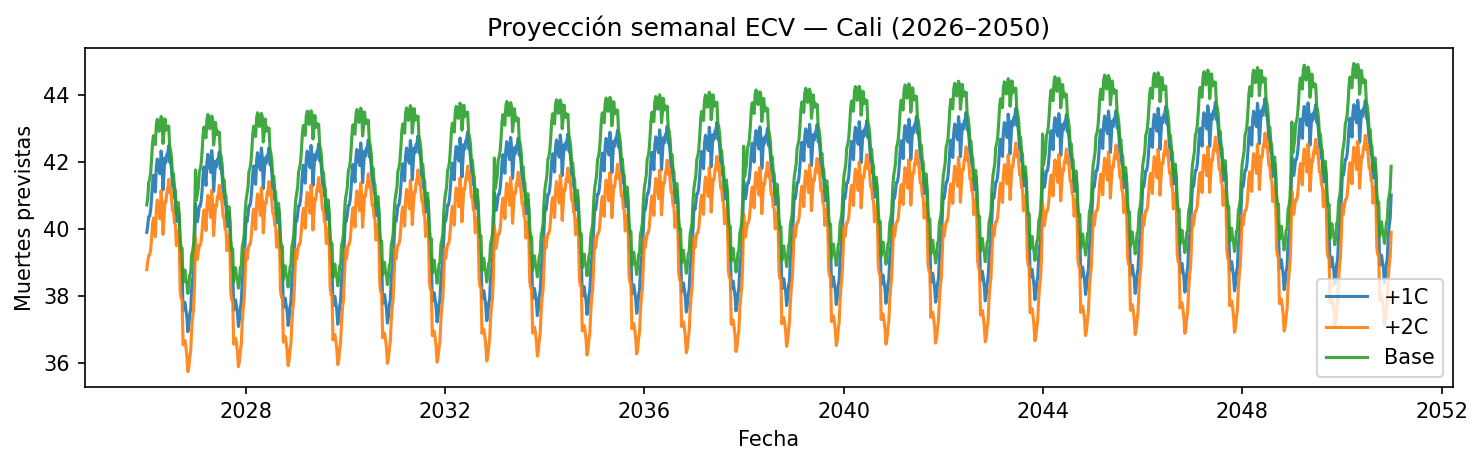

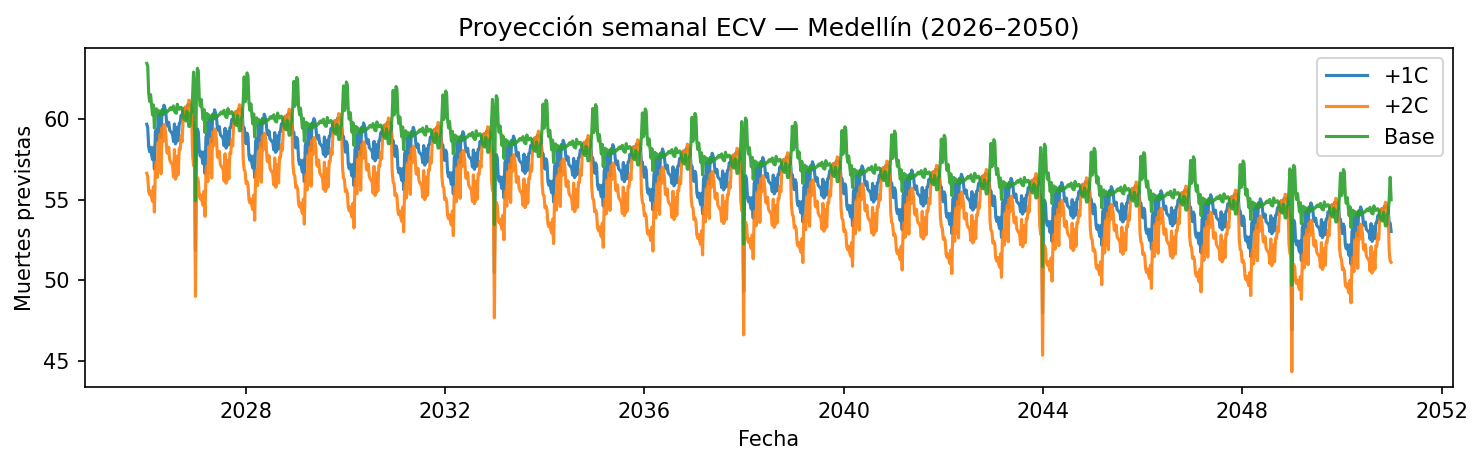

,ciudad,escenario,anio,yhat,y_base,delta_%
0,Barranquilla,+1C,2026,1306.128010,1305.355540,0.059177
1,Barranquilla,+1C,2027,1285.768361,1284.062745,0.132830
2,Barranquilla,+1C,2028,1264.457383,1262.765533,0.133980
3,Barranquilla,+1C,2029,1266.115201,1264.218487,0.150031
4,Barranquilla,+1C,2030,1222.529057,1220.868523,0.136013


In [11]:

df_base = dfw.copy()
df_base['woy'] = df_base['fecha'].dt.isocalendar().week.astype(int)
cols_temp = [c for c in ['tmax','tmin','tmean'] if c in df_base.columns]
cols_all  = cols_temp + (['humedad'] if 'humedad' in df_base.columns else [])
clima = (df_base.groupby(['ciudad','woy'])[cols_all].median().reset_index())

ultima = dfw['fecha'].max()
inicio = pd.to_datetime(f"{max(ultima.year+1, 2026)}-01-01")
offset = (7 - inicio.weekday()) % 7
inicio = inicio + pd.Timedelta(days=offset)
fin    = pd.to_datetime('2050-12-31')
fechas_fut = pd.date_range(inicio, fin, freq='W-MON')
grid = pd.DataFrame({'fecha': fechas_fut})
grid['woy'] = grid['fecha'].dt.isocalendar().week.astype(int)

ciudades = sorted(dfw['ciudad'].dropna().unique())
futuros = []
for c in ciudades:
    g = grid.copy(); g['ciudad'] = c
    g = g.merge(clima[clima['ciudad']==c].drop(columns=['ciudad']), on='woy', how='left')
    for col in cols_all:
        if col in g.columns:
            g[col] = g[col].interpolate(limit_direction='both')
            g[col] = g[col].fillna(g[col].median())
    futuros.append(g.drop(columns=['woy']))
df_fut = pd.concat(futuros, ignore_index=True)

def _delta(df, delta, vars_used):
    d = df.copy()
    for v in vars_used:
        if v in d.columns:
            d[v] = d[v] + delta
    return d

pred_fut = []
for c in ciudades:
    if c not in fits: continue
    used = fits[c]['rr_vars']
    base_c = df_fut[df_fut['ciudad']==c].copy()
    for esc, dd in [('Base', base_c), ('+1C', _delta(base_c, 1.0, used)), ('+2C', _delta(base_c, 2.0, used))]:
        y = predecir(dd, c)[['fecha']].copy()
        y['yhat'] = predecir(dd, c)['yhat'].values
        y['ciudad'] = c; y['escenario'] = esc
        pred_fut.append(y)
pred_fut = pd.concat(pred_fut, ignore_index=True) if pred_fut else pd.DataFrame()
display(pred_fut.head())

# Gráficas
for c in ciudades:
    tmp = pred_fut[pred_fut['ciudad']==c].sort_values('fecha')
    if tmp.empty: continue
    plt.figure(figsize=(10,3.2))
    for esc, g in tmp.groupby('escenario'):
        plt.plot(g['fecha'], g['yhat'], label=esc, alpha=0.9)
    plt.title(f'Proyección semanal ECV — {c} (2026–2050)')
    plt.xlabel('Fecha'); plt.ylabel('Muertes previstas'); plt.legend(); plt.tight_layout()
    plt.show()

# Agregado anual + Δ% vs Base
if not pred_fut.empty:
    pred_fut['anio'] = pred_fut['fecha'].dt.year
    anual = pred_fut.groupby(['ciudad','escenario','anio'])['yhat'].sum().reset_index()
    base = anual[anual['escenario']=='Base'][['ciudad','anio','yhat']].rename(columns={'yhat':'y_base'})
    cmp  = anual.merge(base, on=['ciudad','anio'], how='left')
    cmp['delta_%'] = 100*(cmp['yhat'] - cmp['y_base'])/cmp['y_base']
    display(cmp.head())


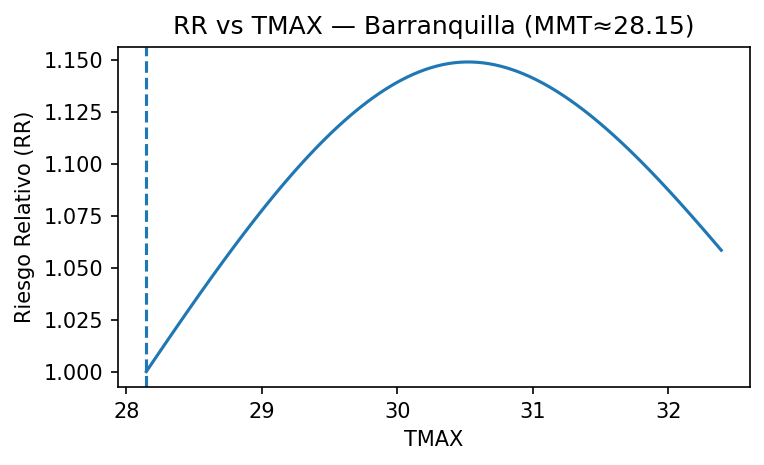

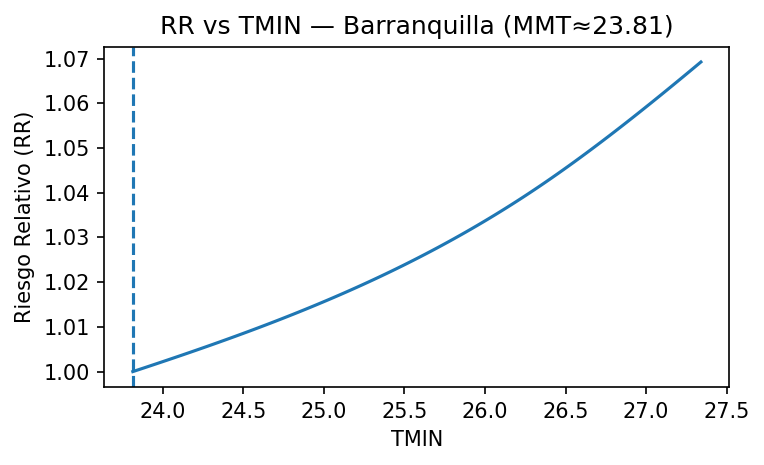

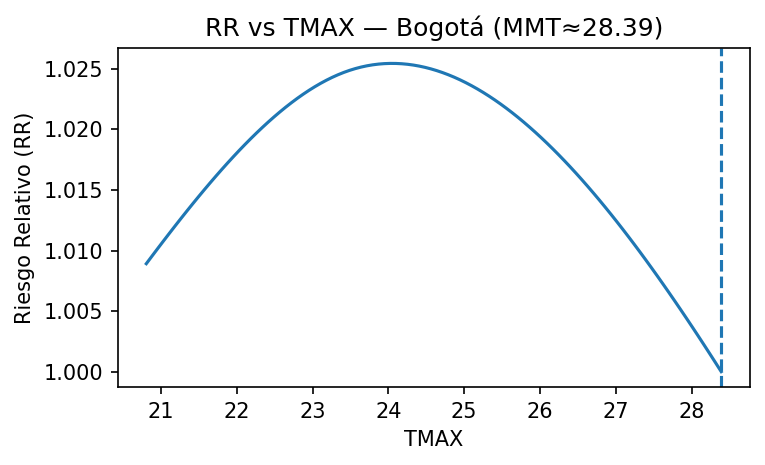

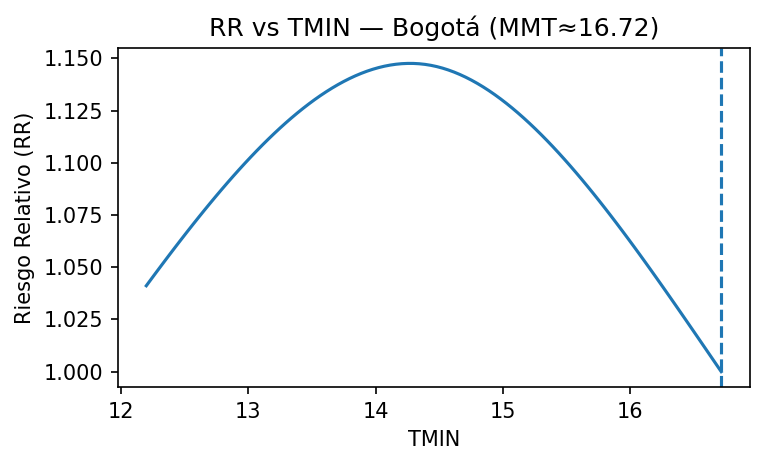

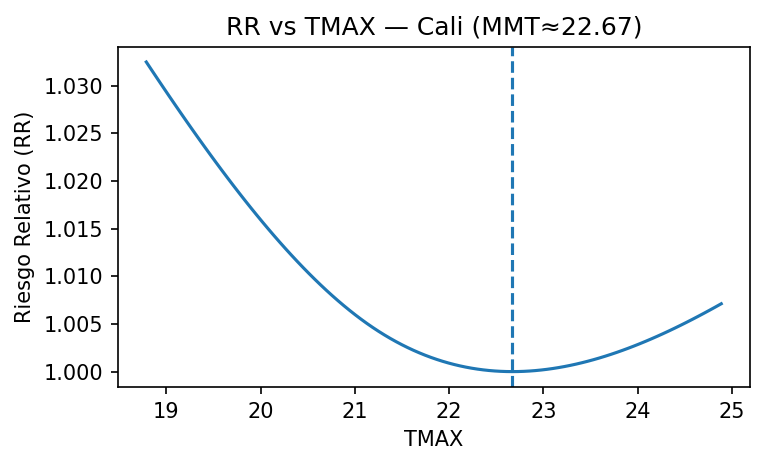

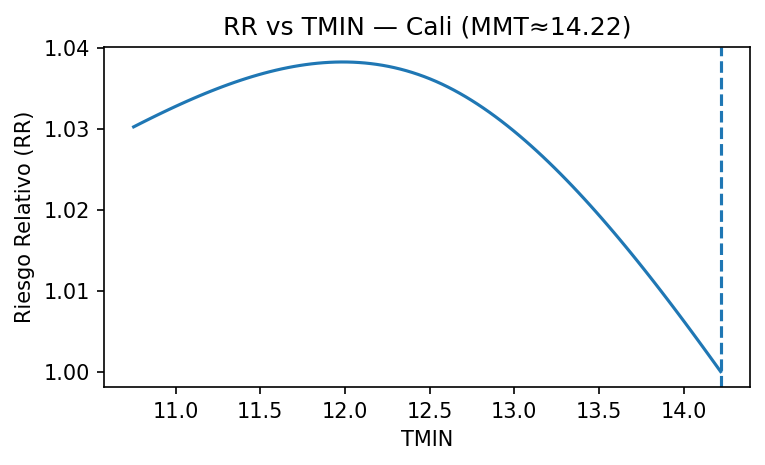

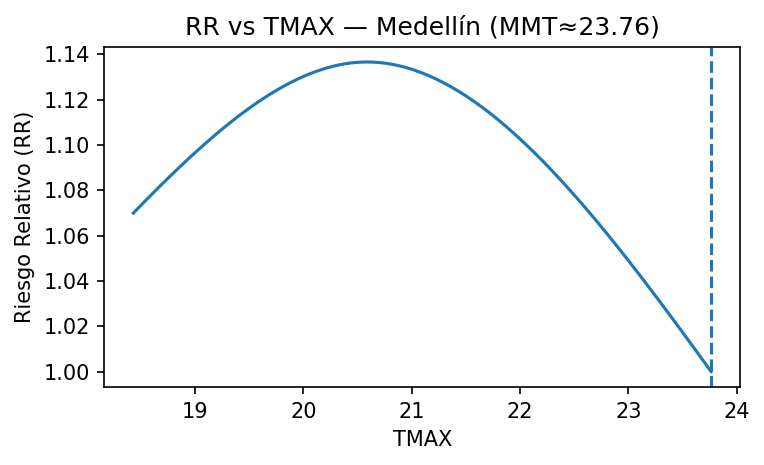

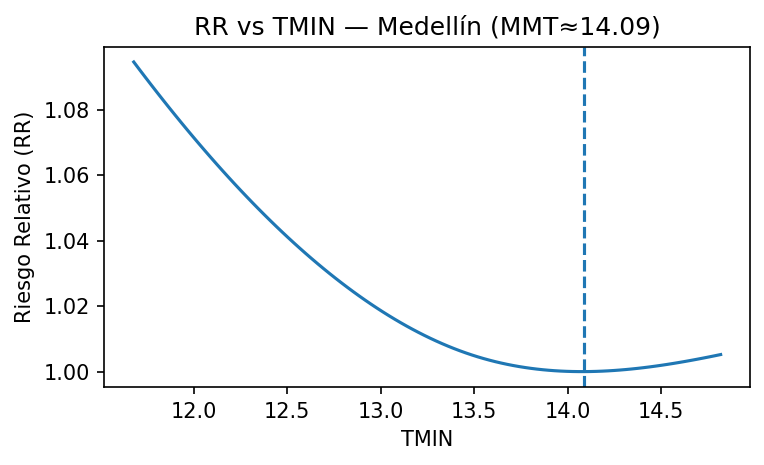

,ciudad,variable,MMT
0,Barranquilla,tmax,28.146200
1,Barranquilla,tmin,23.814129
2,Bogotá,tmax,28.387986
3,Bogotá,tmin,16.716614
4,Cali,tmax,22.668368
5,Cali,tmin,14.218529
6,Medellín,tmax,23.764757
7,Medellín,tmin,14.089814


In [15]:
# === Celda 1: RR + MMT por ciudad (manejo robusto de fechas) ===
import numpy as np
import pandas as pd
import patsy as pt
import matplotlib.pyplot as plt

def _rr_curve_safe(fit, df_city, var, npts=100):
    if var not in df_city.columns or not df_city[var].notna().any():
        return pd.DataFrame()

    d = df_city.dropna(subset=[var, "muertes", "fecha"]).copy()
    d["fecha"] = pd.to_datetime(d["fecha"], errors="coerce")
    d = d.dropna(subset=["fecha"])
    if d.empty:
        return pd.DataFrame()

    origin = pd.to_datetime(fit["origin"])
    d["t_ordinal"] = (d["fecha"] - origin).dt.days
    d["year_sin"]  = np.sin(2*np.pi*d["t_ordinal"]/365.25)
    d["year_cos"]  = np.cos(2*np.pi*d["t_ordinal"]/365.25)
    if "humedad" in d.columns:
        d["humedad"] = d["humedad"].fillna(d["humedad"].median())

    lo, hi = d[var].quantile([0.01, 0.99])
    vals = np.linspace(lo, hi, npts)

    cols_needed = ["tmax","tmin","tmean","t_ordinal","year_sin","year_cos","humedad"]
    base = d.median(numeric_only=True)
    base_df = pd.DataFrame({c:[base.get(c, np.nan)] for c in cols_needed if c in d.columns})

    mu = []
    for v in vals:
        row = base_df.copy(); row[var] = v
        Xg  = pt.build_design_matrices([fit["design_info"]], row)[0]
        # Convertir DesignMatrix a DataFrame y alinear columnas
        try:
            colnames = Xg.design_info.column_names
        except Exception:
            colnames = fit["design_info"].column_names
        Xdf = pd.DataFrame(np.asarray(Xg), columns=colnames)
        for c in fit["columns"]:
            if c not in Xdf.columns:
                Xdf[c] = 0.0
        Xdf = Xdf[fit["columns"]]
        # Reescalar (si hay regularización con 'scale'), excepto intercepto
        if "scale" in fit:
            for c in fit["columns"]:
                if fit.get("intercept_name") and c == fit["intercept_name"]:
                    continue
                if c in fit["scale"].index and fit["scale"][c] != 0:
                    Xdf[c] = Xdf[c] / fit["scale"][c]
            xb = np.dot(Xdf.values, fit["coef_"])
            mu.append(float(np.exp(xb)[0]))
        else:
            mu.append(float(fit["model"].predict(Xdf)[0]))

    out = pd.DataFrame({var: vals, "mu_pred": mu})
    out["RR"] = out["mu_pred"] / out["mu_pred"].min()
    out["MMT"] = out.loc[out["mu_pred"].idxmin(), var]
    return out

def graficar_rr_mmt_por_ciudad():
    resumen = []
    for ciudad, g in dfw.groupby("ciudad"):
        if ciudad not in fits:
            continue
        fit = fits[ciudad]
        for var in fit["rr_vars"]:
            cur = _rr_curve_safe(fit, g, var)
            if cur.empty:
                continue
            mmt = float(cur["MMT"].iloc[0])
            resumen.append({"ciudad": ciudad, "variable": var, "MMT": mmt})
            plt.figure(figsize=(5.2,3.2))
            plt.plot(cur[var], cur["RR"])
            plt.axvline(mmt, linestyle="--")
            plt.title(f"RR vs {var.upper()} — {ciudad} (MMT≈{mmt:.2f})")
            plt.xlabel(var.upper()); plt.ylabel("Riesgo Relativo (RR)"); plt.tight_layout()
            plt.show()
    if resumen:
        return pd.DataFrame(resumen).sort_values(["ciudad","variable"])
    else:
        return pd.DataFrame(columns=["ciudad","variable","MMT"])

rr_mmt_tabla = graficar_rr_mmt_por_ciudad()
display(rr_mmt_tabla)


In [16]:
# === Celda 2: What-if puntual por ciudad (fechas robustas y sin restas array~timestamp) ===
import numpy as np
import pandas as pd

def what_if_semana(ciudad: str, fecha: str | None = None):
    """
    Evalúa el cambio en yhat ante +0.5 °C y +1 °C sobre las variables térmicas
    usadas por el modelo de 'ciudad', manteniendo lo demás fijo.
    'fecha' es 'YYYY-MM-DD'; si None, usa la última semana disponible.
    """
    assert ciudad in fits, f"No hay modelo para {ciudad}"
    fit = fits[ciudad]

    dfc = dfw[dfw["ciudad"]==ciudad].dropna(subset=["fecha"]).copy()
    dfc["fecha"] = pd.to_datetime(dfc["fecha"], errors="coerce")
    dfc = dfc.dropna(subset=["fecha"])
    if dfc.empty:
        print(f"[{ciudad}] Sin datos de fecha.")
        return

    fdt = dfc["fecha"].max() if fecha is None else pd.to_datetime(fecha)
    # Índice de la fila más cercana en el tiempo
    idx_near = (dfc["fecha"] - fdt).abs().idxmin()
    row = dfc.loc[[idx_near], ["fecha","tmax","tmin","tmean","humedad"]].copy()

    # 'predecir' generará los controles a partir de 'fecha'
    base = predecir(row.copy(), ciudad)["yhat"].iloc[0]
    used = fit["rr_vars"]

    for delta in [0.5, 1.0]:
        dd = row.copy()
        for v in used:
            if v in dd.columns:
                dd[v] = dd[v] + delta
        y = predecir(dd, ciudad)["yhat"].iloc[0]
        print(f"[{ciudad}] {fdt.date()}  Base={base:.2f}  +{delta:.1f}°C={y:.2f}  Δ={y-base:+.2f} ({(y-base)/base*100:+.2f}%)")

# Ejemplo: corre para cada ciudad (usando la última fecha disponible)
for c in sorted(dfw["ciudad"].dropna().unique()):
    if c in fits:
        what_if_semana(c)


[Barranquilla] 2019-12-30  Base=27.12  +0.5°C=26.96  Δ=-0.16 (-0.57%)
[Barranquilla] 2019-12-30  Base=27.12  +1.0°C=26.58  Δ=-0.54 (-2.00%)
[Bogotá] 2019-12-30  Base=104.19  +0.5°C=100.05  Δ=-4.13 (-3.97%)
[Bogotá] 2019-12-30  Base=104.19  +1.0°C=95.84  Δ=-8.34 (-8.01%)
[Cali] 2019-12-30  Base=38.74  +0.5°C=38.18  Δ=-0.56 (-1.44%)
[Cali] 2019-12-30  Base=38.74  +1.0°C=37.59  Δ=-1.15 (-2.98%)
[Medellín] 2019-12-30  Base=58.61  +0.5°C=60.37  Δ=+1.76 (+2.99%)
[Medellín] 2019-12-30  Base=58.61  +1.0°C=62.03  Δ=+3.42 (+5.84%)


In [17]:
# === Celda 3: Δ% anual 2026–2050 y chequeo de monotonicidad ===
import numpy as np
import pandas as pd

def _reconstruir_predicciones_si_falta():
    global pred_fut
    if "pred_fut" in globals() and isinstance(pred_fut, pd.DataFrame) and not pred_fut.empty:
        return pred_fut.copy()

    # Reconstruir rápido con climatología semanal
    df_base = dfw.copy()
    df_base["fecha"] = pd.to_datetime(df_base["fecha"], errors="coerce")
    df_base = df_base.dropna(subset=["fecha"])
    df_base["woy"] = df_base["fecha"].dt.isocalendar().week.astype(int)

    cols_temp = [c for c in ["tmax","tmin","tmean"] if c in df_base.columns]
    cols_all  = cols_temp + (["humedad"] if "humedad" in df_base.columns else [])
    clima = (df_base.groupby(["ciudad","woy"])[cols_all].median().reset_index())

    ultima = df_base["fecha"].max()
    inicio = pd.to_datetime(f"{max(ultima.year+1, 2026)}-01-01")
    offset = (7 - inicio.weekday()) % 7
    inicio = inicio + pd.Timedelta(days=offset)
    fin    = pd.to_datetime("2050-12-31")
    fechas_fut = pd.date_range(inicio, fin, freq="W-MON")
    grid = pd.DataFrame({"fecha": fechas_fut})
    grid["woy"] = grid["fecha"].dt.isocalendar().week.astype(int)

    ciudades = sorted(df_base["ciudad"].dropna().unique())
    futuros = []
    for c in ciudades:
        g = grid.copy(); g["ciudad"] = c
        g = g.merge(clima[clima["ciudad"]==c].drop(columns=["ciudad"]), on="woy", how="left")
        for col in cols_all:
            if col in g.columns:
                g[col] = g[col].interpolate(limit_direction="both")
                g[col] = g[col].fillna(g[col].median())
        futuros.append(g.drop(columns=["woy"]))
    df_fut = pd.concat(futuros, ignore_index=True)

    def _delta(df, delta, vars_used):
        d = df.copy()
        for v in vars_used:
            if v in d.columns: d[v] = d[v] + delta
        return d

    pred_list = []
    for c in ciudades:
        if c not in fits:
            continue
        used = fits[c]["rr_vars"]
        base_c = df_fut[df_fut["ciudad"]==c].copy()
        for esc, dd in [("Base", base_c), ("+1C", _delta(base_c, 1.0, used)), ("+2C", _delta(base_c, 2.0, used))]:
            pred = predecir(dd, c)[["fecha","yhat"]].copy()
            pred["ciudad"] = c; pred["escenario"] = esc
            pred_list.append(pred)
    return pd.concat(pred_list, ignore_index=True)

pred_use = _reconstruir_predicciones_si_falta().copy()
pred_use["anio"] = pd.to_datetime(pred_use["fecha"]).dt.year

anual = pred_use.groupby(["ciudad","escenario","anio"])["yhat"].sum().reset_index()
base  = anual[anual["escenario"]=="Base"][["ciudad","anio","yhat"]].rename(columns={"yhat":"y_base"})
cmp   = anual.merge(base, on=["ciudad","anio"], how="left")
cmp["delta_%"] = 100*(cmp["yhat"] - cmp["y_base"])/cmp["y_base"]

# Tabla pivote amigable
pivot = cmp.pivot_table(index=["ciudad","anio"], columns="escenario", values="delta_%")
for col in ["Base","+1C","+2C"]:
    if col not in pivot.columns:
        pivot[col] = np.nan
pivot = pivot[["Base","+1C","+2C"]].rename(columns={"Base":"Δ% Base (=0)"})
display(pivot.head(15))

# Chequeo de monotonicidad por ciudad (promedio 2026–2050)
rows = []
for c, g in cmp.groupby("ciudad"):
    g2 = g.pivot(index="anio", columns="escenario", values="delta_%")
    m1 = float(g2["+1C"].mean()) if "+1C" in g2.columns else np.nan
    m2 = float(g2["+2C"].mean()) if "+2C" in g2.columns else np.nan
    monotone = (abs(m2) + 1e-9 >= abs(m1) - 1e-9) if np.isfinite(m1) and np.isfinite(m2) else np.nan
    rows.append({"ciudad": c, "Δ%_mean_+1C": m1, "Δ%_mean_+2C": m2, "Monotonicidad_|Δ|": bool(monotone) if monotone==monotone else np.nan})

chk = pd.DataFrame(rows).sort_values("ciudad")
print("\nResumen Δ% promedio 2026–2050 y monotonicidad (|+2C| ≥ |+1C|):")
display(chk)


escenario          Δ% Base (=0)       +1C       +2C
ciudad       anio                                  
Barranquilla 2026           0.0  0.059177 -3.257335
             2027           0.0  0.132830 -3.157386
             2028           0.0  0.133980 -3.155709
             2029           0.0  0.150031 -3.132695
             2030           0.0  0.136013 -3.152736
             2031           0.0  0.137139 -3.151091
             2032           0.0  0.059599 -3.256716
             2033           0.0  0.133291 -3.156714
             2034           0.0  0.134438 -3.155041
             2035           0.0  0.150482 -3.132037
             2036           0.0  0.136464 -3.152076
             2037           0.0  0.058965 -3.257645
             2038           0.0  0.132599 -3.157723
             2039           0.0  0.133750 -3.156044
             2040           0.0  0.149805 -3.133025


Resumen Δ% promedio 2026–2050 y monotonicidad (|+2C| ≥ |+1C|):


,ciudad,Δ%_mean_+1C,Δ%_mean_+2C,Monotonicidad_|Δ|
0,Barranquilla,0.121962,-3.171803,True
1,Bogotá,-3.018618,-9.620829,True
2,Cali,-2.079090,-4.700796,True
3,Medellín,-1.905859,-4.652702,True
